# Testing the piecewise motion correction  (with miniscope images and artificial shifts)

---
*Elena Kerjean, Sciences Sorbonne University, Paris*

---

The piecewise motion correction is a Python 3.0 implementation of the NormCorre alogrithm (Pnevmatikakis et al. 2017). It has been optimized for the MiniScope (Cai et al., 2016), a portable microscope for calcium imaging in freely moving animals.

This notebook shows how to test the algorithm only for an image but if you want to see a complet example of NormCorre algorithm using global and piecewise correction on a video, then you can run main_test_motion_correction.py.

Here you can test the algorithme with your own data but no worries, we do provide an example video if you need one. The basic idea is that the image is decomposed in small, overlapping patches. It is assumed that movement artifacts can be well captured by local translation of these patches, with no local deformation. Determining the ensemble of displacements that best explains for each patches the difference with the template gives a 'vector field' of deformation at the scale of the entire image. This is what is used to recalibrate the image to the template and correct for movement artifacts. Below, we describe step by step how to load the data and test the algorithm.




## Basic imports


In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import scipy
import yaml
import sys,os
import h5py as hd
from time import time
import av
import glob
import itertools
from scipy import interpolate
from scipy import signal
import pandas as pd
import re
from tqdm import tqdm
from IPython.core.debugger import Pdb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from copy import copy
from miniscopy.base.sima_functions import *
from miniscopy.base.motion_correction import *
from miniscopy import setup_cluster, CNMFE
from miniscopy import Movie

## Load the inital movie and parameters

Here, we describe the essential steps to start miniscoPy. If you are not familiar with it you should first load the movies from a MiniScope recording session, convert it to a HDF5 file and load the corresponding parameters. When cloning from GitHub, parameter file will located in /bad_movie and an example movie will be downloaded in the next lines.

### Load the movie 

The MiniScope recording system usually outputs a set of avi files in one folder. You can either enter the path to this folder or download an example movie (from our lab, find it here : https://www.dropbox.com/s/oqme4771hlf95ds/A0609_msCam1.avi?dl=1).



In [2]:
folder_name = 'bad_movie/exemple1'
files = glob.glob(folder_name+'/*.avi')
if len(files) == 0:
    import urllib.request
    url = "https://www.dropbox.com/s/oqme4771hlf95ds/A0609_msCam1.avi?dl=1"
    with urllib.request.urlopen(url) as response, open(folder_name+"/A0609_msCam1.avi", 'wb') as out_file:
        data = response.read()
        out_file.write(data)
    files = glob.glob(folder_name+'/*.avi')
    if len(files) == 0: print("No avi files found, please provide one at least")


video_info, videos, dims = get_video_info(files)
print(files)
print(video_info)


['bad_movie/A0609_msCam1.avi']
                             start   end duration
  file_name                                      
0 bad_movie/A0609_msCam1.avi     0  1000     1000


### Load the parameters

- strides : shape of each patches without overlaps.
<li> overlaps : shape of the overlaps between each patches.
<li> upsample_factor_grid : the number by which you want to multiple the number of patches during uspampling.
<li> max_deviation_rigid : the maximum of deviation during the global correction.
<li> max_shifts : the maximum shift that you will apply to each patch at once.
<li> nb_round : the number of time you will apply the algorithm to the whole video.
<li> upsample_factor : parameter of sima functions to find the correct shift. 
<li> filter_size : the size of the gaussian kernel to filter the whole field of view. 
<li> filter_size_patch : the size of the gaussian kernel to filter a patch.
<li> save_original : save the original movie (uncorrected) in the hdf5 file.
<li> block_number: number of images in a block of the video

In [3]:
parameters_global = yaml.load(open(folder_name+'/parameters.yaml', 'r'))
parameters = parameters_global['motion_correction']

print(parameters)


{'strides': (30, 30), 'overlaps': (6, 6), 'upsample_factor_grid': 1, 'max_deviation_rigid': 3, 'max_shifts': [3, 3], 'nb_round': 10, 'upsample_factor': 2, 'filter_size': 10, 'filter_size_patch': 5, 'save_original': False, 'block_size': 200}



Then the avi files are converted to a HDF5 file (The HDF Group. Hierarchical Data Format, version 5, 1997-2018. http://www.hdfgroup.org/HDF5/). HDF5 files are container file that simplify the storage and management of large amount of data, in particular by attaching attributes (i.e. extra information) to every dataset or group it contains.  

In [10]:
try : 
    hdf_mov = get_hdf_file(videos, video_info, dims, parameters['save_original'])
except OSError: 
    pass # Here it means that the hdf_mov has already been loaded.
except:
    raise


# 1. Create the template and the shifted image 
Now that the movie is loaded, we can start testing the motion correction algorithm. We load the first image of the movie and use it as a **template**. We select a patch in this video and move it around to test how the algorithm is able to capture this change.

The selected patch is an area of 100 by 100 pixels surrounding the most fluorescent point in the template. We move it by a certain amount in the two directions of the image plane, we call it the **shifted image** (yes, not very original). 

### 1.1 Initialize the shift 
In this example we take a 3 pixels shit to the left (N.B : a positive vertical shift brings the cropped area towards the top). You're welcome to change it and play with other values, it's a notebook after all!

In [11]:
shift_appli = [0,3] #shift in direction  (-h,-w)

### 1.2  Extract the first image of the movie 
Remember, we use it as the template.

In [13]:
movie = hdf_mov['movie'] # variable pointing towards the movie stored in the hdf file in the disk.
template = movie[0].copy().reshape(dims)

### 1.3 Create the shifted image

Let's look for the most fluorescent point in the image and select a 100 x 100 pixel area arround it.

#### 1.3.1 Get the maximum of fluorescence of the template and determine the area that will be shifted 

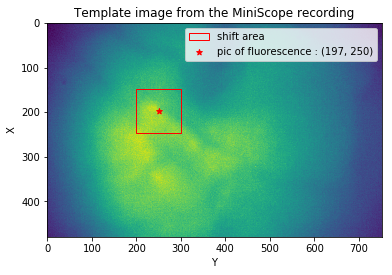

In [14]:
max_fluo_template, mf_template = get_max_fluo(template,parameters)

top,bottom, left, right = max_fluo_template[0]-50,max_fluo_template[0]+50,max_fluo_template[1]-50,max_fluo_template[1]+50
rect = patches.Rectangle((left,top),100,100,linewidth=1,edgecolor='r',facecolor='none',label = 'shift area')


fig2, ax2 = plt.subplots()
ax2.imshow(template)
ax2.add_patch(copy(rect))
ax2.scatter(max_fluo_template[1], max_fluo_template[0], marker ='*', color='r', label = "pic of fluorescence : " + str(max_fluo_template))
ax2.set_title('Template image from the MiniScope recording')
ax2.set_xlabel('Y')
ax2.set_ylabel('X')
ax2.legend(loc='best')


#### 1.3.2 Create an artifically deformed image and get the new pic of fluorescence
Here, we shift the selected area by the amount determined above, and display the result.

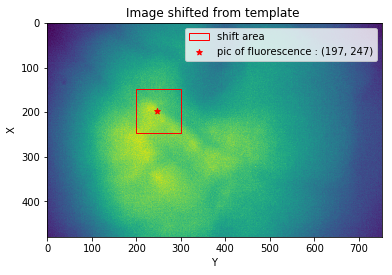

In [15]:
image =  template.copy()
image[top : bottom, left:right] = image[top + shift_appli[0] : bottom + shift_appli[0], left+ shift_appli[1]: right + shift_appli[1]]
max_fluo_image, mf_image = get_max_fluo(image,parameters)

fig3,ax3 = plt.subplots()
ax3.imshow(image)
ax3.add_patch(copy(rect))
ax3.scatter(max_fluo_image[1], max_fluo_image[0], marker ='*', color='r', label = "pic of fluorescence : " + str(max_fluo_image))
ax3.set_title('Image shifted from template ')
ax3.set_xlabel('Y')
ax3.set_ylabel('X')
ax3.legend(loc='best')

### 1.4 Compare the template with the shifted image

For small displacement (e.g. 3 pixels as in this example), the image is not strikingly different, we just see that the peak fluorecence has moved accordingly. **CHECK THE POSITION OF THE PIC OF FLUORESCENCE IN THE LEGEND TO SEE THE SHIFT**.


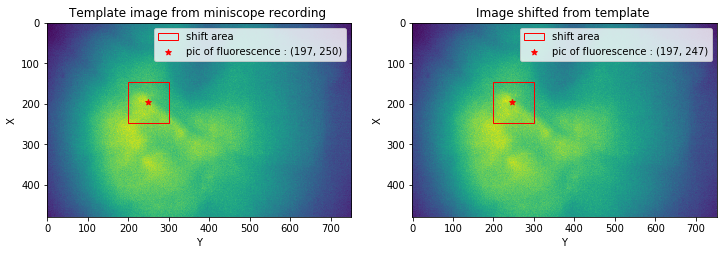

In [17]:

fig,(ax2,ax3) = plt.subplots(1,2, figsize=(12,12))
ax2.imshow(template)
ax2.add_patch(copy(rect))
ax2.scatter(max_fluo_template[1], max_fluo_template[0], marker ='*', color='r', label = "pic of fluorescence : " + str(max_fluo_template))
ax2.set_title('Template image from miniscope recording ')
ax2.set_xlabel('Y')
ax2.set_ylabel('X')
ax2.legend(loc='best')

ax3.imshow(image)
ax3.add_patch(copy(rect))
ax3.scatter(max_fluo_image[1], max_fluo_image[0], marker ='*', color='r', label = "pic of fluorescence : " + str(max_fluo_image))
ax3.set_title('Image shifted from template ')
ax3.set_xlabel('Y')
ax3.set_ylabel('X')
ax3.legend(loc='best')
plt.show()



# 2. Create a vector field of the displacement vectors

Following the Normcorre algorithm, we now divide the image into overlapping patches. Then, for each patch, we calculate the local displacement vector by comparing the shifted image with the template. 

To determine the vector field of displacement in the **shifted image**, we divide both the **shifted image** and the **template** into patches of 36 by 36 pixels that overlap by 6 pixels with each other. For each patch, we calculate a displacement vector by comparing the **shifted image** to the **template**. This procedure leads to a vector field of the displacement vectors on the **shifted image**. Each displacement vector is then applied to the corresponding patch to correct the inital shift. The corrected patchs are then reassembled to give the **corrected image**.


### 2.1  Divide the image into patches 


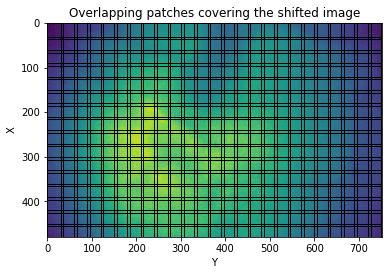

In [24]:
patches_index, wdims, pdims    = get_patches_position(dims, **parameters)
num_patches = pdims[0]*pdims[1]
patch_LIST = []
for i in range (0,num_patches):
    top_patch, left_patch = patches_index[i]
    patch_LIST.append(patches.Rectangle((left_patch,top_patch),wdims[1],wdims[0],linewidth=1,edgecolor='black',facecolor='none'))

fig4,ax4 = plt.subplots()
ax4.imshow(image)
for i in range (0,num_patches):
    ax4.add_patch(patch_LIST[i])
ax4.set_title('Overlapping patches covering the shifted image')
ax4.set_xlabel('Y')
ax4.set_ylabel('X')
plt.savefig("test.pdf")

### 2.2 Determine the displacement for each patch
Best performance to determine the vector field is obtained at low spatial resolution. So images are first filtered. Then we compute the (x,y) displacement for each patch (i.e. the vector field) stored in two separate matrices (*shift_img_x* and *shift_img_y*).

In our example, we should thus obtain a *shift_img_y* matrix full of 0s except in the shifted area where it is supposed to be 3. The *shift_img_x* displacement matrix should be only zeros.


In [30]:
shifts_patch = np.zeros((len(patches_index),2))
for i,patch_pos in enumerate(patches_index):
	xs, xe, ys, ye = (patch_pos[0],np.minimum(patch_pos[0]+wdims[0],dims[0]-1),patch_pos[1],np.minimum(patch_pos[1]+wdims[1],dims[1]-1)) # s = start, e = exit
	filtered_image = low_pass_filter_space(image[xs:xe,ys:ye].copy(), parameters['filter_size_patch'])
	filtered_template = low_pass_filter_space(template[xs:xe,ys:ye].copy(), parameters['filter_size_patch'])
	shifts_patch[i], error, phasediff = register_translation(filtered_template, filtered_image, parameters['upsample_factor'],"real",None,None, parameters['max_shifts']) #coordinate given back in order Y,X
  
shift_img_x = shifts_patch[:,0].reshape(pdims)
shift_img_y = shifts_patch[:,1].reshape(pdims) 

### 2.3  Upsampling (optional)
It may be crucial in certain cases to increase the spatial resolution of the movement correction, in other words, to use smaller patches. To this end, you can upsample the number of patches by changing this parameter: *parameters['upsample_factor_grid']*.

In [32]:
# upsampling 
new_overlaps    = parameters['overlaps']
new_strides     = tuple(np.round(np.divide(parameters['strides'], parameters['upsample_factor_grid'])).astype(np.int))
upsamp_patches_index, upsamp_wdims, upsamp_pdims = get_patches_position(dims, new_strides, new_overlaps)

# resize shifted image
shift_img_x     = cv2.resize(shift_img_x, (upsamp_pdims[1],upsamp_pdims[0]), interpolation = cv2.INTER_CUBIC)
shift_img_y     = cv2.resize(shift_img_y, (upsamp_pdims[1],upsamp_pdims[0]), interpolation = cv2.INTER_CUBIC)



### 2.4 Vizualize the vector field



In [33]:
X,Y,U,V,Xp,Yp = vector_field(shift_img_x,shift_img_y,new_strides,upsamp_wdims,upsamp_pdims,dims)

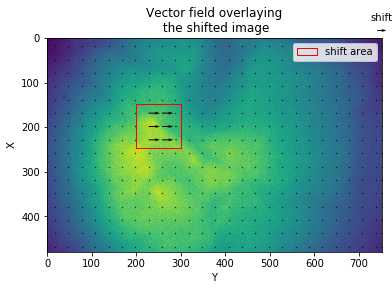

In [34]:
fig5, ax5 = plt.subplots()
ax5.imshow(image)
q = ax5.quiver(X, Y, U, V, angles='xy')
ax5.quiverkey(q, 0.9, 0.9, 2, r'shift', labelpos='N',coordinates='figure')
ax5.scatter(Xp,Yp,marker=".", c ='black', s = 0.5)
ax5.add_patch(copy(rect))
ax5.set_xlim([0, dims[1]])
ax5.set_title('Vector field overlaying\n the shifted image')
ax5.set_xlabel('Y')
ax5.set_ylabel('X')
ax5.legend(loc=1)

plt.show()


And now, let's look at a more realistic example.

100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


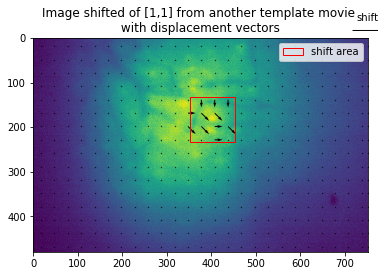

In [36]:
folder_name_2='bad_movie/exemple2'

parameters_global_2 = yaml.load(open(folder_name_2+'/parameters.yaml', 'r'))
parameters_2 = parameters_global_2['motion_correction']

shift_appli_2 = [1,1]
image_2, X_2 , Y_2, U_2, V_2,Xp_2,Yp_2,rect_2,dims_2 = get_vector_field_image(folder_name_2,shift_appli_2,parameters_2)

fig6, ax6 = plt.subplots()
ax6.imshow(image_2)
q_2 = ax6.quiver(X_2, Y_2, U_2, V_2, angles='xy')
ax6.quiverkey(q_2, 0.9, 0.9, 2, r'shift', labelpos='N',coordinates='figure')
ax6.scatter(Xp_2,Yp_2,marker=".", c ='black', s = 0.5)
ax6.set_xlim([0, dims_2[1]])
ax6.add_patch(rect_2)
ax6.set_title('Image shifted of [1,1] from another template movie \n with displacement vectors ' )
ax6.legend(loc=1)

plt.show()


## 3. Obtain the corrected image
We're almost done! Last step: re-assemble the displaced patches to reconstruct an image as much as possible similar to the template.

### 3.1 Move each patch iteratively

In [37]:
num_tiles           = np.prod(upsamp_pdims) #number of patches
max_shear           = np.percentile([np.max(np.abs(np.diff(ssshh, axis=xxsss))) for ssshh, xxsss in itertools.product([shift_img_x, shift_img_y], [0, 1])], 75) #?What is that   
total_shifts        = np.vstack((shift_img_x.flatten(),shift_img_y.flatten())).transpose()
new_upsamp_patches  = np.ones((num_tiles, upsamp_wdims[0], upsamp_wdims[1]))*np.inf
for i, patch_pos in enumerate(upsamp_patches_index):
    if total_shifts[i].sum():#where there is a shift
        xs, xe, ys, ye  = (patch_pos[0],np.minimum(patch_pos[0]+upsamp_wdims[0],dims[0]-1),patch_pos[1],np.minimum(patch_pos[1]+upsamp_wdims[1],dims[1]-1))
        patch           = image[xs:xe,ys:ye]
        new_upsamp_patches[i,0:patch.shape[0],0:patch.shape[1]] = apply_shift_iteration(patch.copy(), total_shifts[i], border_nan = False)

### 3.2 Assemble the corrected patches together


In [38]:
new_image = join_patches(image,max_shear,upsamp_wdims,new_overlaps,upsamp_pdims,upsamp_patches_index,patch_pos,total_shifts,new_upsamp_patches)

### 4. Vizualize the template / the shifted image /  the corrected image 


<Figure size 432x288 with 0 Axes>

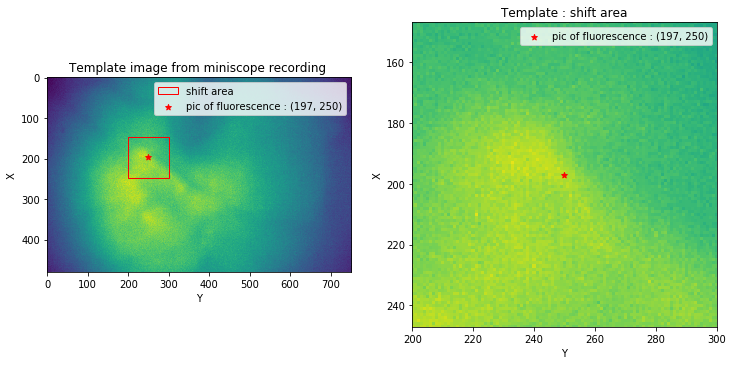

<Figure size 432x288 with 0 Axes>

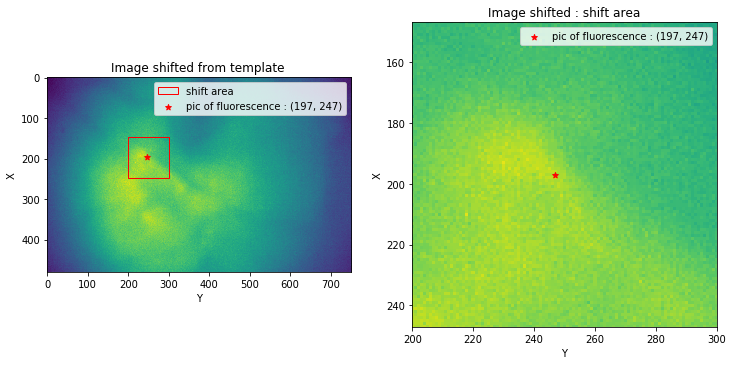

<Figure size 432x288 with 0 Axes>

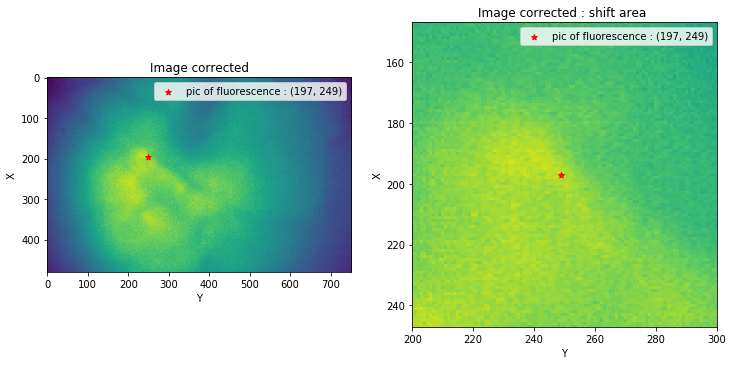

In [39]:
max_fluo_Nimage, mf_Nimage = get_max_fluo(new_image,parameters)


plt.figure()
fig2,(ax2,ax2z) = plt.subplots(1,2, figsize=(12,6))
ax2.imshow(template)
ax2.add_patch(copy(rect))
ax2.scatter(max_fluo_template[1], max_fluo_template[0], marker ='*', color='r',label = "pic of fluorescence : " + str(max_fluo_template))
ax2.set_title('Template image from miniscope recording ')
ax2.set_xlabel('Y')
ax2.set_ylabel('X')
ax2.legend(loc='best')

ax2z.imshow(template)
ax2z.scatter(max_fluo_template[1], max_fluo_template[0], marker ='*', color='r',label = "pic of fluorescence : " + str(max_fluo_template))
ax2z.set_title('Template : shift area')
ax2z.set_xlabel('Y')
ax2z.set_ylabel('X')
ax2z.set_xlim(left,right)
ax2z.set_ylim(bottom,top)
ax2z.legend(loc='best')
plt.show()


plt.figure()
fig3,(ax3,ax3z)= plt.subplots(1,2, figsize=(12,6))
ax3.imshow(image)
ax3.add_patch(copy(rect))
ax3.scatter(max_fluo_image[1], max_fluo_image[0], marker ='*', color='r',label = "pic of fluorescence : " + str(max_fluo_image))
ax3.set_title('Image shifted from template ')
ax3.set_xlabel('Y')
ax3.set_ylabel('X')
ax3.legend(loc='best')

ax3z.imshow(image)
ax3z.scatter(max_fluo_image[1], max_fluo_image[0], marker ='*', color='r',label = "pic of fluorescence : " + str(max_fluo_image))
ax3z.set_title('Image shifted : shift area')
ax3z.set_xlabel('Y')
ax3z.set_ylabel('X')
ax3z.set_xlim(left,right)
ax3z.set_ylim(bottom,top)
ax3z.legend(loc='best')
plt.show()

plt.figure()
fig7, (ax7,ax7z) = plt.subplots(1,2, figsize=(12,6))
ax7.imshow(new_image)
ax7.scatter(max_fluo_Nimage[1], max_fluo_Nimage[0], marker ='*', color='r', label = "pic of fluorescence : " + str(max_fluo_Nimage))
ax7.set_title('Image corrected')
ax7.set_xlabel('Y')
ax7.set_ylabel('X')
ax7.legend(loc='best')

ax7z.imshow(new_image)
ax7z.scatter(max_fluo_Nimage[1], max_fluo_Nimage[0], marker ='*', color='r', label = "pic of fluorescence : " + str(max_fluo_Nimage))
ax7z.set_title('Image corrected : shift area ')
ax7z.set_xlabel('Y')
ax7z.set_ylabel('X')
ax7z.set_xlim(left,right)
ax7z.set_ylim(bottom,top)
ax7z.legend(loc='best')


plt.show()